<a href="https://colab.research.google.com/github/sagewoodard/GEE_Sentinel2_Data/blob/main/CNN_Sentinel2_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate Google Earth Engine
import ee
ee.Authenticate() # Sign in with Google account
ee.Initialize(project='satellite-data-442019') # Initialize API

In [ ]:
# Extract data from Google Earth engine

# Define the region (Grand Canyon coordinates)
region = ee.Geometry.Rectangle([-113.1182, 35.7540, -112.1147, 36.2461])

# Define the date range
start_date = '2023-06-01'
end_date = '2023-08-31'

# Use the updated Sentinel-2 Surface Reflectance dataset
dataset = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate(start_date, end_date) \
    .filterBounds(region) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Keep images with <20% cloud cover

# Print dataset information for confirmation
print(dataset.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32612', 'crs_transform': [60, 0, 199980, 0, -60, 4000020]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32612', 'crs_transform': [10, 0, 199980, 0, -10, 4000020]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32612', 'crs_transform': [10, 0, 199980, 0, -10, 4000020]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32612', 'crs_transform': [10, 0, 199980, 0, -10, 4000020]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32612', 'crs_transform': [20, 0, 199980, 0, -20, 4000020

In [ ]:
# Visualize and explore the data

import folium

# Define a map centered on the Grand Canyon
map = folium.Map(location=[36.0, -112.5], zoom_start=10)

# Add a visualization layer (true color composite)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
    'min': 0,
    'max': 3000,  # Adjust range based on dataset values
    'gamma': 1.4
}
map_id_dict = ee.Image(dataset.mosaic()).getMapId(vis_params)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Map Data &copy; Google Earth Engine',
    overlay=True
).add_to(map)

display(map)

In [ ]:
# Export the cleaned and mosaicked data to Google Drive for further preprocessing and analysis

# Mosaic the images and clip to the region
mosaic = dataset.mosaic().clip(region).uint16()

# Eport the mosaic as a GeoTIFF file
export_task = ee.batch.Export.image.toDrive(
    image=mosaic,
    description='Grand_Canyon_S2_SR',
    scale=30, # Spatial resolution in meters
    region=region.getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)
export_task.start()

print('Export started. Monitor progress in the Earth Engine Task Manager.')

Export started. Monitor progress in the Earth Engine Task Manager.


In [ ]:
!pip install rasterio

In [ ]:
# Load the data from Google Drive

# Import rasterio
import rasterio

# File path in My Drive
file_path = '/content/drive/MyDrive/Grand_Canyon_S2_SR.tif'

# Read the GeoTIFF file
with rasterio.open(file_path) as src:
    image_data = src.read()  # Load data as a NumPy array
    print("Image shape:", image_data.shape)  # (bands, height, width)

Image shape: (23, 1831, 3725)


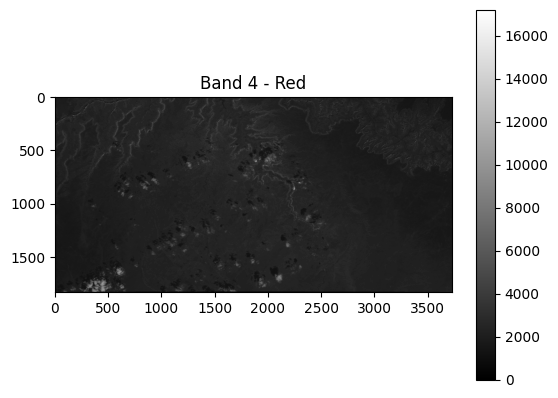

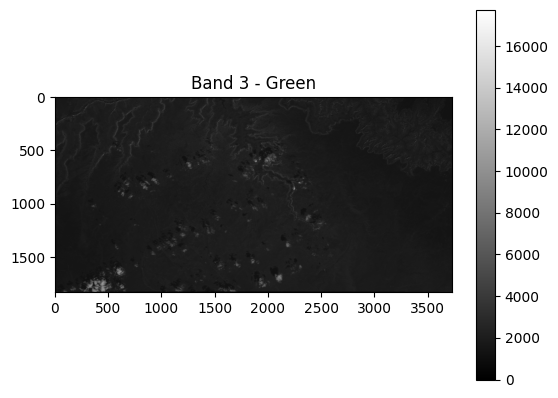

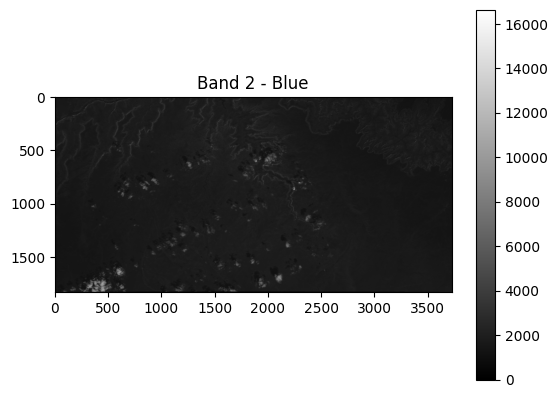

In [ ]:
# Inspect and visualize the data

import matplotlib.pyplot as plt

# Visualize Band 4 (Red)
plt.imshow(image_data[2], cmap='gray')  # Assuming Band 4 (index 2) is Red
plt.title('Band 4 - Red')
plt.colorbar()
plt.show()

# Visualize Band 3 (Green)
plt.imshow(image_data[1], cmap='gray')  # Assuming Band 3 (index 1) is Green
plt.title('Band 3 - Green')
plt.colorbar()
plt.show()

# Visualize Band 2 (Blue)
plt.imshow(image_data[0], cmap='gray')  # Assuming Band 2 (index 0) is Blue
plt.title('Band 2 - Blue')
plt.colorbar()
plt.show()

In [ ]:
# Select only RGB bands (assume B4=Red, B3=Green, B2=Blue)
rgb_data = image_data[[3, 2, 1], :, :]  # Adjust indices based on dataset metadata
print("RGB data shape (bands, height, width):", rgb_data.shape)

# Normalize the pixel values
normalized_data = rgb_data / 3000.0  # Adjust the scaling factor based on dataset range
print("Normalized data shape:", normalized_data.shape)  # Ensure normalization was applied

RGB data shape (bands, height, width): (3, 1831, 3725)
Normalized data shape: (3, 1831, 3725)


In [ ]:
# Extract patches: divide the large GeoTIFF into smaller patches for model training
import numpy as np

# Define patch size
patch_size = 256
patches = []

# Extract patches
for i in range(0, normalized_data.shape[1], patch_size):
    for j in range(0, normalized_data.shape[2], patch_size):
        patch = normalized_data[:, i:i+patch_size, j:j+patch_size]
        if patch.shape[1] == patch_size and patch.shape[2] == patch_size:  # Ensure consistent patch size
            patches.append(patch)

# Convert list of patches to a NumPy array and reorder dimensions for TensorFlow
patches = np.array(patches)
patches = np.moveaxis(patches, 1, -1)  # Change shape to (num_patches, height, width, channels)
print("Patches shape (num_patches, height, width, channels):", patches.shape)

# Simulate labels (replace with actual labels if available)
labels = np.random.randint(0, 3, len(patches))  # Example: 3 classes

Patches shape (num_patches, height, width, channels): (98, 256, 256, 3)


In [ ]:
# Split the data: split the patches into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(patches, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (68, 256, 256, 3)
Validation set shape: (15, 256, 256, 3)
Test set shape: (15, 256, 256, 3)


In [ ]:
# Build a model: Define a simple Convolutional Neural Network (CNN) for classification or analysis
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # Adjust for RGB
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model: fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.3791 - loss: 15.0329 - val_accuracy: 0.4667 - val_loss: 1.5068
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3865 - loss: 1.8476 - val_accuracy: 0.3333 - val_loss: 1.6451
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3302 - loss: 1.2470 - val_accuracy: 0.4667 - val_loss: 1.1558
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4017 - loss: 1.0734 - val_accuracy: 0.4000 - val_loss: 1.0697
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5685 - loss: 0.9678 - val_accuracy: 0.3333 - val_loss: 1.4473
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3913 - loss: 1.1038 - val_accuracy: 0.4000 - val_loss: 1.1142
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6903 - loss: 0.8909 - val_accuracy: 0.4667 - val_loss: 1.0500
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5186 - loss: 0.9509 - val_accuracy: 0.3333 - val_loss: 1.1791
Epoch 9/

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 0.3333 - loss: 1.0805
Test accuracy: 0.33


In [ ]:
# Save the trained model to Google Drive
model.save('/content/drive/My Drive/terrain_model.h5')
print('Model saved successfully')

Model saved successfully


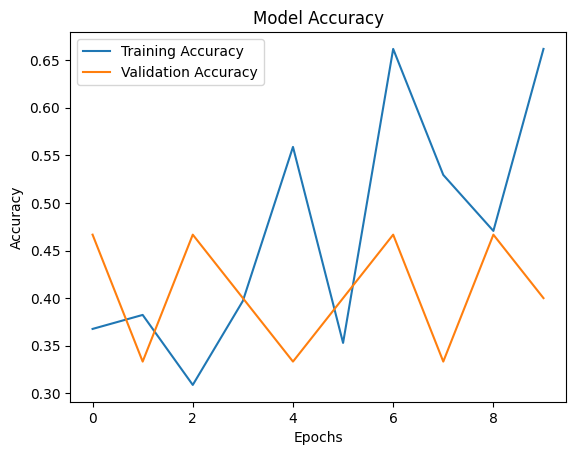

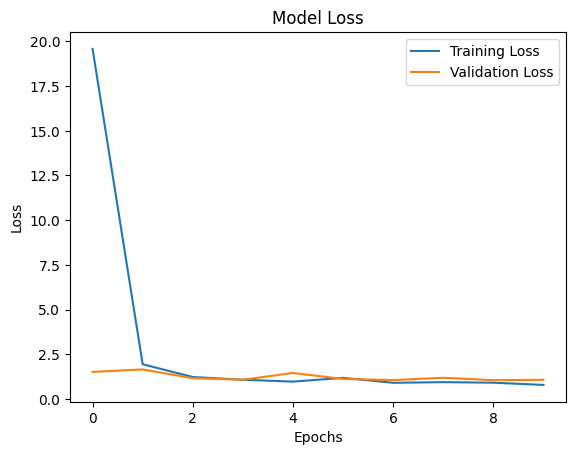

In [ ]:
# Visualize training history
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Use the model to make predictions on the test set

# Generate predictions for the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Print the first 10 predictions
print("Predicted classes for first 10 test samples:", predicted_classes[:10])
print("Actual classes for first 10 test samples:", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
Predicted classes for first 10 test samples: [2 2 1 2 2 1 1 1 2 2]
Actual classes for first 10 test samples: [1 0 0 2 1 1 1 2 0 2]


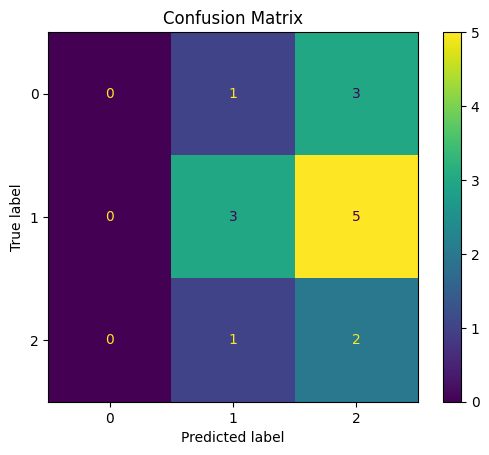

In [ ]:
# Analyze results: create a confusion matrix to visualize how well the model is performing on each class
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])  # Replace with actual class labels
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()